In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf, c_multi_gamma_sf_approx
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
dist = 2
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

xvals = np.linspace(-30, 30, 100000)

[1.00045562 1.2639036  1.00001584] [0.04895381 1.50627305 0.00372613]


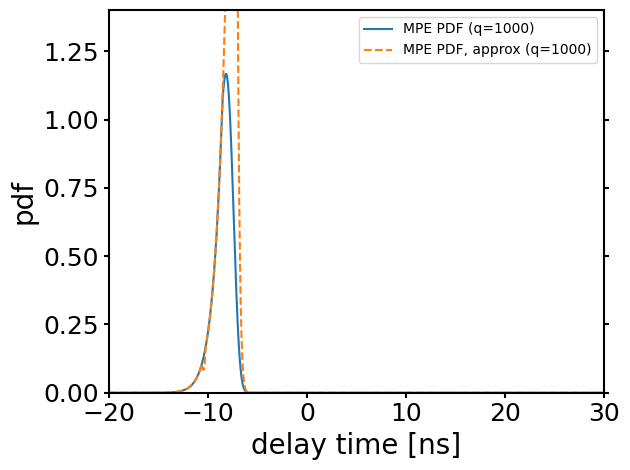

In [4]:
c_multi_gamma_prob_vx = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0))
c_multi_gamma_sf_vx = jax.jit(jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0))
c_multi_gamma_sf_approx_vx = jax.jit(jax.vmap(c_multi_gamma_sf_approx, (0, None, None, None, None), 0))

n_p = 1000

fig, ax = plt.subplots()
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_approx = c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0)

yval1 = n_p * probs * jnp.power(sfs, n_p-1)
ymax = np.max(yval1)
plt.plot(xvals, yval1, label=f'MPE PDF (q={n_p})')

yval2 = n_p * probs * jnp.power(sfs_approx, n_p-1)
plt.plot(xvals, yval2, label=f'MPE PDF, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 1.2 * ymax],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()



In [5]:
%timeit c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1).block_until_ready()

27.6 ms ± 21.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%timeit c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0).block_until_ready()

40.8 ms ± 29.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0).block_until_ready()

7.49 ms ± 23.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(probs)

[5.13425424e-24 5.14462173e-24 5.15500996e-24 ... 1.20819429e-03
 1.20816127e-03 1.20812826e-03]


In [9]:
n_photons = 1000
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_approx = c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0)
mpe_log_probs = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs)
mpe_log_probs_approx = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs_approx)

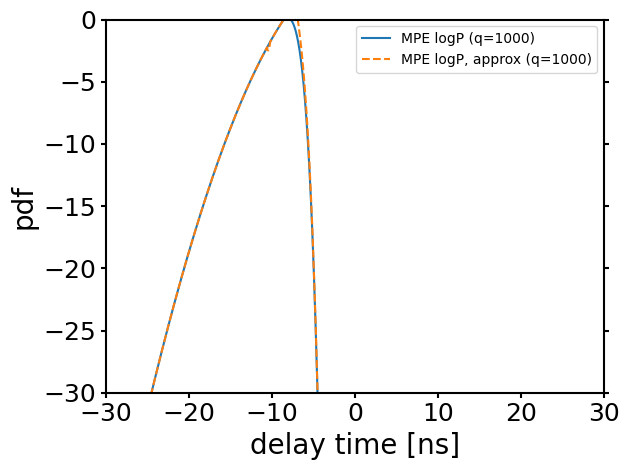

In [10]:
fig, ax = plt.subplots()

plt.plot(xvals, mpe_log_probs, label=f'MPE logP (q={n_p})')
plt.plot(xvals, mpe_log_probs_approx, label=f'MPE logP, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-30, 30],
                     'ylim':[-30, 0.0],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()